In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.20.0


In [23]:
# Create a list with the filepaths for training and testing
train_dir = Path('train')
test_dir = Path('test')
val_dir = Path('validation')

train_filepaths = list(train_dir.glob(r'**/*.jpg'))
test_filepaths = list(test_dir.glob(r'**/*.jpg'))
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

In [24]:
def image_processing(filepath):
    # Using .parent.name is safer than .split("/")[-2]
    labels = [fp.parent.name for fp in filepath]

    filepath_series = pd.Series(filepath, name='Filepath').astype(str)
    labels_series = pd.Series(labels, name='Label')

    df = pd.concat([filepath_series, labels_series], axis=1)
    return df.sample(frac=1).reset_index(drop=True)

In [25]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

print(f"Train: {len(train_df)}, Test: {len(test_df)}, Val: {len(val_df)}")

Train: 2855, Test: 340, Val: 340


In [26]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['sweetpotato' 'cabbage' 'eggplant' 'grapes' 'pear' 'carrot' 'lettuce'
 'peas' 'onion' 'lemon' 'cucumber' 'capsicum' 'bell pepper' 'raddish'
 'chilli pepper' 'mango' 'spinach' 'paprika' 'tomato' 'turnip'
 'watermelon' 'kiwi' 'pineapple' 'garlic' 'sweetcorn' 'potato' 'jalepeno'
 'beetroot' 'orange' 'banana' 'pomegranate' 'ginger' 'soy beans'
 'cauliflower' 'corn' 'apple']


In [27]:
train_df.head()

,Filepath,Label
0,train\sweetpotato\Image_62.jpg,sweetpotato
1,train\cabbage\Image_67.jpg,cabbage
2,train\eggplant\Image_97.jpg,eggplant
3,train\grapes\Image_88.jpg,grapes
4,train\pear\Image_52.jpg,pear


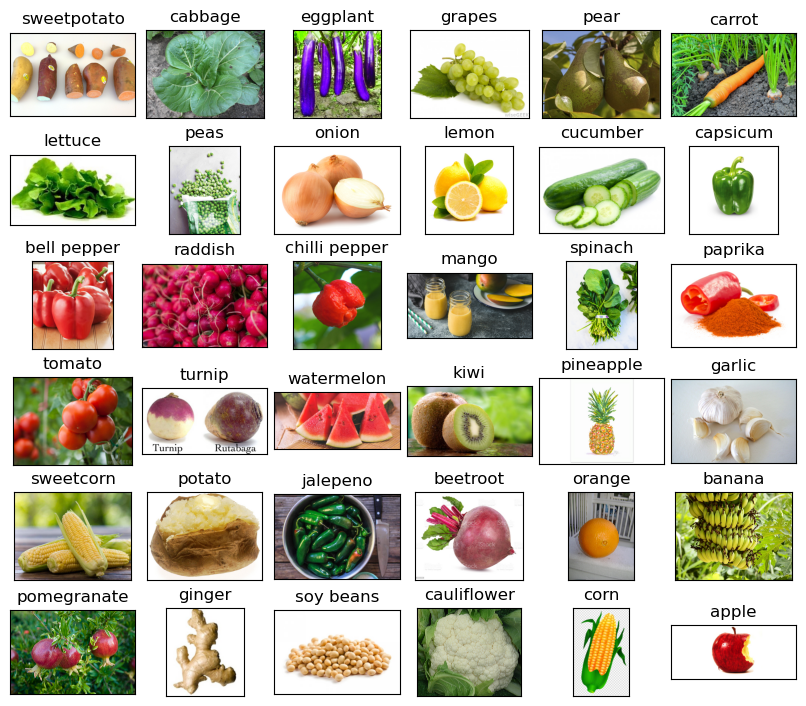

In [28]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [29]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [30]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [31]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [32]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [33]:
# found validation image belonging to classes

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [34]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [35]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.5275 - loss: 1.8143 - val_accuracy: 0.8324 - val_loss: 0.5544
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.8081 - loss: 0.6027 - val_accuracy: 0.9176 - val_loss: 0.2803
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.8918 - loss: 0.3466 - val_accuracy: 0.9559 - val_loss: 0.2025
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9285 - loss: 0.2259 - val_accuracy: 0.9353 - val_loss: 0.2202
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9524 - loss: 0.1527 - val_accuracy: 0.9529 - val_loss: 0.1739


In [36]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


['chilli pepper',
 'garlic',
 'chilli pepper',
 'pomegranate',
 'jalepeno',
 'cucumber',
 'orange',
 'ginger',
 'paprika',
 'spinach',
 'pear',
 'bell pepper',
 'raddish',
 'watermelon',
 'paprika',
 'lettuce',
 'jalepeno',
 'eggplant',
 'soy beans',
 'beetroot',
 'onion',
 'onion',
 'lettuce',
 'bell pepper',
 'lemon',
 'pineapple',
 'mango',
 'cauliflower',
 'lettuce',
 'pear',
 'pomegranate',
 'pear',
 'potato',
 'pear',
 'bell pepper',
 'onion',
 'beetroot',
 'carrot',
 'cucumber',
 'cucumber',
 'ginger',
 'beetroot',
 'onion',
 'apple',
 'beetroot',
 'watermelon',
 'kiwi',
 'cauliflower',
 'ginger',
 'beetroot',
 'tomato',
 'sweetpotato',
 'mango',
 'apple',
 'jalepeno',
 'raddish',
 'sweetcorn',
 'raddish',
 'sweetpotato',
 'grapes',
 'garlic',
 'soy beans',
 'eggplant',
 'raddish',
 'cucumber',
 'sweetcorn',
 'mango',
 'potato',
 'apple',
 'sweetcorn',
 'soy beans',
 'eggplant',
 'sweetcorn',
 'spinach',
 'kiwi',
 'ginger',
 'banana',
 'corn',
 'raddish',
 'sweetcorn',
 'potato'

In [37]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [39]:
img = output('test/cabbage/Image_1.jpg')
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'cabbage'

In [ ]:
model.save('FV.h5')

: 